In [1]:
# encoding=utf8

# Linear Regression Analysis

In [13]:
import sys
print(dir(sys.modules["builtins"]))

['ArithmeticError', 'AssertionError', 'AttributeError', 'BaseException', 'BlockingIOError', 'BrokenPipeError', 'BufferError', 'BytesWarning', 'ChildProcessError', 'ConnectionAbortedError', 'ConnectionError', 'ConnectionRefusedError', 'ConnectionResetError', 'DeprecationWarning', 'EOFError', 'Ellipsis', 'EnvironmentError', 'Exception', 'False', 'FileExistsError', 'FileNotFoundError', 'FloatingPointError', 'FutureWarning', 'GeneratorExit', 'IOError', 'ImportError', 'ImportWarning', 'IndentationError', 'IndexError', 'InterruptedError', 'IsADirectoryError', 'KeyError', 'KeyboardInterrupt', 'LookupError', 'MemoryError', 'ModuleNotFoundError', 'NameError', 'None', 'NotADirectoryError', 'NotImplemented', 'NotImplementedError', 'OSError', 'OverflowError', 'PendingDeprecationWarning', 'PermissionError', 'ProcessLookupError', 'RecursionError', 'ReferenceError', 'ResourceWarning', 'RuntimeError', 'RuntimeWarning', 'StopAsyncIteration', 'StopIteration', 'SyntaxError', 'SyntaxWarning', 'SystemError

In [14]:
# only necessary if you're running Python 2.7 or lower
from __future__ import print_function
from builtins import range

# import matplotlib and define our alias
from matplotlib import pyplot as plt

# plot figures within the notebook rather than externally
%matplotlib inline

# numpy
import numpy as np

# scipy 
import scipy

## Overview

This week, we'll be diving into some of the details involved with fitting models to data building on the concepts Prof. John Johnson taught last week using **linear regression**. Although linear regression appears simple at first glance, it actually has a surprisingly amount of depth. Most importantly, it provides an accessible way to get a handle on several big concepts in data analysis (and especially model fitting) and illustrate how to apply them in practice.

# The Problem

Let's say that we have a bunch of observations of [**Cepheid variable stars**](https://en.wikipedia.org/wiki/Classical_Cepheid_variable). Cepheids have a well-defined relationship between their **period** and **luminosity**, which allows astronomers to use them as [standard candles](https://en.wikipedia.org/wiki/Cosmic_distance_ladder#Standard_candles) when trying to calibrate distances. For each Cepheid we observe their **V-band [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)** (a logarithmic measure of luminosity) $M_V$ as well as their period $P$.

Define our **independent variable** (regressor, explanatory variable, etc.) to be $x \equiv \log_{10} \left(\frac{P}{10\,\textrm{days}} \right)$ and our **dependent variable** (regressand, response variable, etc.) to be $y \equiv M_v$. Our **model** for the data is then

$$ y = \alpha + \beta x \quad . $$

# Mock Data

Let's use [this](https://en.wikipedia.org/wiki/Classical_Cepheid_variable#Period-luminosity_relation) period-luminosity relationship

$$ y = -2.43x - 4.05 $$

to generate some mock data.

Let's assume we have 10 stars **[uniformly distributed](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)** in the range $[-8, -4)$ (i.e. from -6 to -4, including -6 but excluding -4) and that we can measure $x$ and $y$ perfectly (we'll get back to errors later). The only uncertainty is some **intrinsic scatter** around the relation, which constitutes an error term $\epsilon$ which we will take to be **[normally distributed](https://en.wikipedia.org/wiki/Normal_distribution)** with mean $\mu=0$ and standard deviation $\sigma=0.3$. So our final model looks like this:

$$ x_i \sim \textrm{Unif}(-6, -4) $$
$$ \epsilon_i \sim \textrm{Normal}(\mu=0, \sigma=0.3) $$
$$ y_i = -2.43x_i - 4.05 + \epsilon_i $$

where the index $i$ just is telling us we observed this quantity for object $i$.

In [15]:
# define the period-luminosity relationship
def plr(x):
    return -2.43 * x - 4.05

In [16]:
# generate random data points from the cepheid period-luminosity relationship

n = 10  # number of objects
sigma = 0.3  # intrinsic scatter

x = np.random.uniform(-6, -4., n)  # absolute v-band magnitude
e = np.random.normal(0.0, sigma, n)  # scatter
y = plr(x) + e  # observed log(period)

**Take a few seconds to play around with the random number generation to get a sense for what these data look like.**

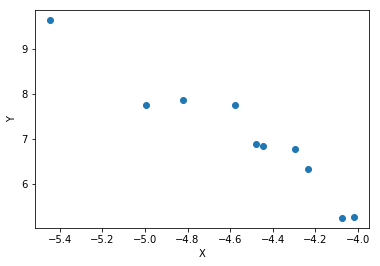

In [17]:
# plotting results
plt.plot(x, y, 'o')
plt.xlabel('X')
plt.ylabel('Y')

**Now let's assume we have no idea what the actual period-luminosity relationship actually is, and we would like to fit for our coefficients $\alpha$ and $\beta$. What determines a "good" fit? And how much "better" is one fit compared to another? Think about how we would quantify this and discuss your thinking with your classmates.**

# Non-Bayes View (Linear Least Squares)

In a more "data mining"-oriented perspective, the way to solve this problem is to define an appropriate **loss function** $L(\boldsymbol{\Theta} \,|\, \mathbf{D})$ that we hope to minimize, where $\boldsymbol{\Theta}$ contains all the parameters of interest (here $\alpha$ and $\beta$) and $\mathbf{D}$ contains all our data. Defining $\mathbf{x} \equiv \lbrace x_1, \dots, x_n \rbrace$ and $\mathbf{y} \equiv \lbrace y_1, \dots, y_n \rbrace$, let's write our loss function as the sum of the *squares* of the **residuals**

$$ L(\alpha, \beta \,|\, \mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n} \left( \Delta y_i \right)^2 \equiv \sum_{i=1}^{n} \left( y(x) - y_i \right)^2 = \sum_{i=1}^{n} \left( \alpha + \beta x_i - y_i \right)^2 \quad . $$

Let's define our linear relationship and this particular loss function below.

In [18]:
# linear fit (takes input *vector* `theta`)
def linear(theta):
    return theta[0] + theta[1] * x

# loss function
def loss(theta):
    return sum((linear(theta) - y)**2)

# Minimizing Our Loss Function

To minimize our loss function, we need to find the [critical points](https://en.wikipedia.org/wiki/Critical_point). As a quick review, these are just all the points where

$$ \frac{\partial f(\boldsymbol{\Theta})}{\partial \Theta_i} = 0 $$

for all parameters $\Theta_i$ of interest within $\boldsymbol{\Theta}$. In our case, we get:

$$ \frac{\partial L}{\partial \alpha} = \sum_{i=1}^{n} 2(\alpha + \beta x_i - y_i) = 0 $$
$$ \frac{\partial L}{\partial \beta} = \sum_{i=1}^{n} 2\beta(\alpha + \beta x_i - y_i) = 0 $$

This gives us two linear equations with two unknowns, which we can solve *exactly* using linear algebra to get an analytic best-fit solution $\hat{\alpha}$ and $\hat{\beta}$. You're welcome to try and solve this explicitly now; we'll come back to this later.

For now, we'll minimize our loss function using the `minimize` package contained within `scipy.optimize`.

In [19]:
# import minimize
from scipy.optimize import minimize

**Using the [documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html), see if you can figure out how to use `minimize` to get the best-fit parameters `theta` based on our loss function `loss`.** Spend some time digging around to see if you can understand both how the output is stored (as a [`dict`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)) and what some of the terms mean. We'll get back to these quantities in more detail later.

In [21]:
# minimizing
results = minimize(...)

# best-fit solution
theta_res = results[...]

# print results
print(results)
print('Truth:', [-4.05, -2.43])
print('Fit:', theta_res)

# plot results
plt.plot(x, y, 'o', label='observed')
plt.plot(x, linear(theta_res), 'o', label='predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

TypeError: minimize() missing 1 required positional argument: 'x0'

# Bayesian View

Looking back, the way we did things above seems very "sloppy". In particular, what's the motivation for picking our loss function? Why sum of squares instead of, say, a sum of cubes, $\sum_i(\Delta y_i)^3$, or a sum of absolute values, $\sum_i |\Delta y_i|$? The choice of loss function can dramatically affect our final results by changing how much information/weight each point contributes to the fit.

From the Bayesian point of view, the above analysis has two critical flaws: 
1. the loss function is defined in an "ad hoc" way and
2. our *prior beliefs* are not specified anywhere.

Since the "loss function" is ultimately just an extension of our underlying model, choosing a loss function means we're actually implicitly choosing a model. Based on our knowledge/assumptions about the data and our model then, we should be able to *derive* our loss function directly.

In this example, Bayes' Theorem can be written as

$$ P(\alpha, \beta \,|\, \mathbf{y}) = \frac{P(\mathbf{y} \,|\, \alpha, \beta) \, P(\alpha, \beta)}{P(\mathbf{y})} $$

where $P(\alpha, \beta)$ is the **prior** on $\alpha$ and $\beta$, $P(\mathbf{y} \,|\, \alpha, \beta)$ is the **likelihood** of $\mathbf{y}$ given $\alpha$ and $\beta$, $P(\mathbf{y})$ is the **evidence** for $\mathbf{y}$ over all possible $\alpha$ and $\beta$, and $P(\alpha, \beta \,|\, \mathbf{y})$ is the posterior (what we're usually interested in) for $\alpha$ and $\beta$ given $\mathbf{y}$.

Recall that our original model was

$$ \epsilon_i \sim \textrm{Normal}(\mu=0, \sigma=0.3) $$
$$ y_i = -2.43x_i - 4.05 + \epsilon_i $$

For a given $\alpha$ and $\beta$, we then expect that our residuals $\Delta y_i$ should follow the same distribution as our noise $\epsilon_i$ (normally distributed with mean $\mu=0$ and standard deviation $\sigma=0.3$). The probability of observing residual $\Delta y_i$ conditioned on our model parameters $\alpha$ and $\beta$ (i.e. the likelihood) is then

$$ P(\Delta y_i \,|\, \alpha, \beta) = \frac{1}{\sigma\sqrt{2\pi}} \exp \left[ - \frac{(\Delta y_i)^2}{2\sigma^2} \right] \quad .$$

In [22]:
# normal distribution
def normal(x, mu, sigma):
    norm = 1. / (sigma * np.sqrt(2 * np.pi))
    return norm * np.exp( - (mu - x)**2 / (2 * sigma**2))

# plot locations on distribution
xgrid = np.linspace(-1.5, 1.5, 100)
ygrid = normal(xgrid, 0, sigma)
resid = linear(theta_res) - y
plt.plot(xgrid, ygrid)
plt.plot(resid, normal(resid, 0, sigma), 'o')
plt.xlabel('Jitter')
plt.ylabel('PDF')

NameError: name 'theta_res' is not defined

Assuming all our data points are independent, the probabilities all multiply, giving us

$$ P(\Delta \mathbf{y} \,|\, \alpha, \beta) = \prod_{i=1}^{n} P(\Delta y_i \,|\, \alpha, \beta) = \left(\frac{1}{\sigma\sqrt{2\pi}}\right)^n \exp \left[ - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (\Delta y_i)^2 \right] \quad . $$

**Compute the likelihood and "log-likelihood" $\ln P(\Delta \mathbf{y} \,|\, \alpha, \beta)$ for the best-fit parameters you derived above. Do those numbers look reasonable? Why or why not?**

In [23]:
# likelihood/loglikelihood

print('Like:', ...)
print('Logl:', ...)

Like: Ellipsis
Logl: Ellipsis


# The "Meaning" of Our Loss Function

The last term inside the exponential should look extremely familiar -- it's our squared loss function from before!

More explicitly,

$$ L(\alpha,\beta \,|\, \mathbf{x}, \mathbf{y}) = -2\sigma^2 \left[ \ln P(\Delta \mathbf{y} \,|\, \alpha, \beta) + n \ln(\sigma \sqrt{2\pi}) \right] \quad \Rightarrow \quad -A \times L(\alpha,\beta \,|\, \mathbf{x}, \mathbf{y}) + B = \ln P(\Delta \mathbf{y} \,|\, \alpha, \beta) $$

where $A$ and $B$ are arbitrary constants. Since multiplicate/additive constants distribute across all terms within our loss function, they don't actually affect the minimum value in any way. **Minimizing a squared loss is thus equivalent to maximizing the likelihood under the assumption of uniform Gaussian noise**. So our choice of a squared loss above actually not only is a good choice, it is the **only choice that makes any sense given our underlying model**.

# Short Aside

Before moving on, I want to emphasize two things. First, **in a Bayesian paradigm this result and our interpretation of it is fundamentally dependent on our model.** In other words, if we assume, for instance, a different type of noise or that the errors are not all equal, then our likelihood (and the equivalent loss function) will change. So switching to different loss functions means we're switching to an entirely different model. This might be appropriate if we don't actually know what the appropriate model is (model selection is hard).

Second, **there's no need to shackle ourselves to a strictly Bayesian paradigm**. Tons of real-world applications modify loss functions in ways that can be difficult to translate back into a full Bayesian model but are straightforward to interpret algorithmically.

# Improper Priors

One final addendum: although our results above worked with the likelihood, we actually need it to work with the posterior. This is not a big deal though: taking the log of Bayes theorem gives us

$$ \ln P(\alpha, \beta \,|\, \mathbf{y}) = \ln P(\mathbf{y} \,|\, \alpha, \beta) + \ln P(\alpha, \beta) - \ln P(\mathbf{y}) $$

so if we just set $P(\alpha, \beta)$ to be a constant everywhere ($P(\mathbf{y})$ is already a constant) our **maximum-likelihood** results will not change. 

**Take a second to think about what exactly we've done here, since this is a deep but subtle point. What does our prior actually do? Is it even a prior? Is this physically/philosophically possible? Discuss these issues with your neighbor and try to construct another example of a similar type of this type of "improper" prior.**

**Extra Challenge: Can you construct the prior used here using limiting behavior from other, well-defined priors?**

# Relationship to $\chi^2$

Last week, Prof. Johnson mentioned this thing called **chi-square** ($\chi^2$), which is defined as

$$ \chi^2(\alpha, \beta \,|\, \mathbf{x}, \mathbf{y}) \equiv \sum_{i=1}^{n} \frac{\left( \Delta y_i \right)^2}{\sigma_i^2} = \sum_{i=1}^{n} \frac{\left( y(x) - y_i \right)^2}{\sigma_i^2} = \sigma^{-2} L(\alpha, \beta \,|\, \mathbf{x}, \mathbf{y}) \quad . $$

This can most straightforwardly be interpreted as an **error-weighted** metric for determining the goodness-of-fit, where the weights $w_i = \sigma_i^{-2}$. These make a lot of sense given the $\sigma^{-2}$ term that arises within our assumption of Normal errors. This perspective is also useful since these types of error-weighted metrics can be easily generalized to all sorts of problems.

In our particular case where all the errors are the same ($\sigma_1 = \dots = \sigma_n = \sigma$; a phenomenon known as **homoscedasticity**), we see that all this does is add a multiplicative normalization to our loss function. As we shown above, this doesn't affect our **maximum-likelihood** (i.e. best-fit, minimum-loss, etc.) solution at all.

This definition of $\chi^2$, however, can also be interpreted another way: instead of just adding up residuals, we want to first **normalize** each residual $\Delta y_i$ by the **expected dispersion** ($\sigma_i$). If we imagine that we have perfectly modeled the underlying relationship, the residuals should just be random noise. We can thus define $\chi^2$ as:

$$ \chi^2 = \left(\frac{X_1 - \mu_1}{\sigma_1}\right)^2 + \dots + \left(\frac{X_n - \mu_n}{\sigma_n}\right)^2 $$ 
$$ X_1, \dots, X_n \overset{i.i.d.}{\sim} \textrm{Normal}(\mu_1,\sigma_1), \dots, \textrm{Normal}(\mu_n,\sigma_n) $$

There's a really neat property of normal random variables we can exploit here: all normal random variables can be written as shifted and scaled version of the **standard normal** as

$$ X_i \sim \sigma_i Z_i + \mu_i \quad , \quad Z_i \sim \textrm{Normal}(0, 1) \quad . $$

This enables us to rewrite our original expression as

$$ \chi^2 = \left(\frac{X_1 - \mu_1}{\sigma_1}\right)^2 + \dots + \left(\frac{X_n - \mu_n}{\sigma_n}\right)^2 = Z_1^2 + \dots + Z_n^2 $$

where all quantities are defined as above. 

In other words, we expect $\chi^2$ to have a particular *[distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution)* (specifically, a **probability density function or PDF**) based on the sum of squares of $n$ standard normal random variables. I can't emphasize enough how *Incredibly Important* this fact is. This singular result tells us two main things:
1. We *expect* some amount of dispersion from our results. Too much dispersion means we're **under-fitting** (we need a better model), while too little dispersion means we're **over-fitting** (our model is "too good" and likely fitting noise).
2. We actually have a theoretical distribution $P(\chi^2 \,|\, \textrm{dof})$ that tells us the probability of observing $\chi^2$ to have a certain value for a given **degree of freedom** (dof).

Let's simulate this explicitly below. **Using the provided code snippets, generate realizations of our $\chi^2$ distributions for different numbers of data points (`npoints`) to see how the distribution changes as we add more data.**

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


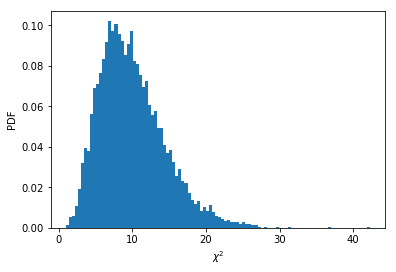

In [24]:
npoints, nrepeats = 10, 10000  # number of points and repeat realizations

# generate standard normal N(0,1) distributed random numbers with shape (npoints, nrepeats)
# square all entries
# sum up all results along 0th axis (sum over `npoints` axis; leaves `nrepeats` number of entries)
chi2 = (np.random.normal(0., 1., size=(npoints, nrepeats))**2).sum(axis=0)

# plot results
plt.hist(chi2, bins=nrepeats/100, normed=True)
plt.xlabel('$\chi^2$')
plt.ylabel('PDF')

The $\chi^2$ distribution actually has a closed-form solution, which is accessible (along with many other distributions) via [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html). Let's use the analytic results stored there to check our numerical results above.

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


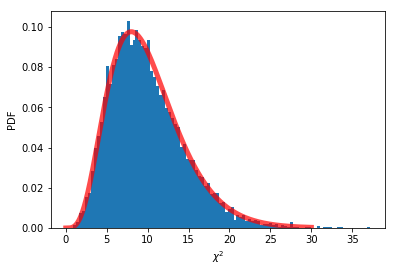

In [25]:
from scipy import stats
xgrid = np.linspace(0., n*3., 1000)
ygrid = stats.chi2.pdf(xgrid, n)
chi2 = (np.random.normal(0., 1., size=(npoints, nrepeats))**2).sum(axis=0)

# plot results
plt.hist(chi2, bins=nrepeats/100, normed=True)
plt.plot(xgrid, ygrid, color='red', lw=5, alpha=0.7)
plt.xlabel('$\chi^2$')
plt.ylabel('PDF')

# Understanding "Effective" Degrees of Freedom

This result, however, where the $\textrm{dof}=n$, only holds theoretically. In practice, the process of actually finding our best-fit solution *removes* degrees of freedom from our final result. For example, if we had two data points, our best-fit line would always fit them perfectly, leaving us with $\chi^2 = 0$. This means we actually want to compare our result to $P(\chi^2 \,|\, \textrm{dof} = n - p)$ with an **effective dof** of $n-p$, where $n$ is the number of data points and $p$ is the number of **free parameters**. (You can prove this result, but I've left it out since it's a bit more involved and not really relevant for our purposes.)

To illustrate this, in the cell below I've gone through and simulated our entire fit a bunch of times and have computed the $\chi^2$ from each fit. The underlying $\chi^2(n)$ and $\chi^2(n-p)$ distributions are over-plotted for comparison.

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


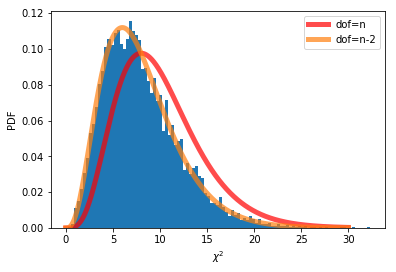

In [26]:
# minimizing
npoints, nrepeats = 10, 10000  # number of points and repeat realizations
chi2_arr = np.empty(nrepeats)
for i in range(nrepeats):
    xt = np.random.uniform(-6, -4., npoints)  # temp x values
    et = np.random.normal(0.0, sigma, npoints)  # temp y truth values
    yt = plr(xt) + et  # observed log(period)  # temp y obs values
    rt = minimize(lambda theta: sum((theta[0] + theta[1] * xt - yt)**2) / sigma**2, [0., 2.])  # minimize loss
    chi2_arr[i] = rt['fun']  # extract chi2 value

# plot results
plt.hist(chi2_arr, bins=nrepeats/100, normed=True)  # simulated values
plt.plot(xgrid, stats.chi2.pdf(xgrid, n), color='red', lw=5, alpha=0.7, label='dof=n')  # chi2 with dof=n
plt.plot(xgrid, stats.chi2.pdf(xgrid, n - 2), lw=5, alpha=0.7, label='dof=n-2')  # chi2 with dof=n-2
plt.legend()
plt.xlabel('$\chi^2$')
plt.ylabel('PDF')

This result is extremely useful when trying to compare results from different models, which we'll take advantage of in just a second.

# `polyfit`

In the cases above where we're dealing with least-squares minimization, `numpy` actually has a method [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) that computes the full analytic solution for any degree polynomial (which we'll hopefully come back to later). It also has a nice built-in class [`poly1d`](https://docs.scipy.org/doc/numpy/reference/routines.polynomials.poly1d.html) that automatically turns those solutions into functions!

**Compare the solution from `polyfit` to the one you calculated earlier. How does it look? Try adding more polynomial terms to the fit, up to $b_0 + b_1 x + \dots + b_{n-1}x^{n-1}$. Does it improve? How much did you *expect* it to improve, given that you're adding additional free parameters to the fit?**

In [27]:
# example code
theta_fit = np.polyfit(x, y, 1)
func = np.poly1d(theta_fit)
func(x)

array([ 8.32915289,  6.77542457,  6.17096186,  7.83907506,  5.55045379,
        6.86592083,  6.33732067,  7.14950803,  5.71072463,  9.61965467])

# Model Comparison

Now we want to compare our best-fit models to see if the data itself can reasonably discriminate against our different models (starting from a line with $p=2$ parameters and progressing to more complex polynomials). First, using our results from earlier, we know that we can evaluate the relative probabilities using our $P(\chi^2 \,|\, n-p)$ distribution. One easy test is then just taking the ratio of these probabilities to get an **odds ratio** 

$$ R_{ij} = \frac{P(\chi^2 \,|\, n-p_i)}{P(\chi^2 \,|\, n-p_j)} \quad . $$ 

This tells us, in a relative sense, how much more likely one best-fit model with $p_i$ parameters is compared to another model with $p_j$ parameters. The "rule of thumb" for chi-square distributions is that the odds ratio should be around a factor of $e$ (i.e. the log-odds $\ln R_{ij} \sim 1$)

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


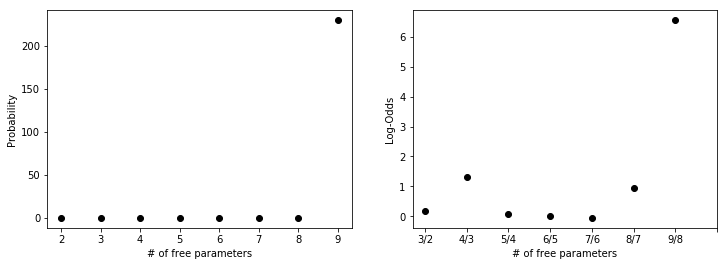

In [28]:
# define our chi2 function (compact)
def chi2(nparams):
    return sum((y - np.poly1d(np.polyfit(x, y, nparams-1))(x))**2 / sigma**2)

# plot results (probabilities)
plt.figure(figsize=(12, 4))
plt.subplot(121)  # 1 row, 2 columns, subplot 1
for i in range(2, n + 1):
    plt.plot(i, stats.chi2.pdf(chi2(i), n-i), 'ko')
    plt.xlabel('# of free parameters')
    plt.ylabel('Probability')
    
# plot results (log odds ratio)
plt.subplot(122)
for i in range(2, n-1):
    plt.plot(i+1, np.log(stats.chi2.pdf(chi2(i+1), n-i-1) / stats.chi2.pdf(chi2(i), n-i)), 'ko')
plt.xticks(range(3, n+1), ['{0}/{1}'.format(j+1, j) for j in range(2, n-1)])
plt.xlabel('# of free parameters')
plt.ylabel('Log-Odds')

And that's the end of this introductory notebook. In the next notebook, we'll look into how to derive **errors** on our best-fit models.